In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
repo_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning'
experiments_path = os.path.join(repo_path, 'experiments/HAM10000/6:3:1')

In [17]:
def get_df(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    return df

def get_best_epoch(df, window_size):
    val_nll = df.val_nll.values
    windowed_nll = [sum(val_nll[index-window_size:index])/window_size \
                      for index in range(window_size, len(val_nll))]
    return df.iloc[window_size+np.argmin(windowed_nll)]

In [18]:
random_states = [1001, 2001, 3001]
random_states = [4001, 5001, 6001]
prior_scales = np.logspace(0, 9, num=10)
lr_0s = np.logspace(-1, -4, num=4)
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
window_size = 5

In [19]:
columns = ['random_state', 'prior_scale', 'test_auroc', 'test_loss', 'test_nll', 
           'test_prior', 'train_auroc', 'train_loss', 'train_nll', 'train_prior', 
           'val_auroc', 'val_loss', 'val_nll', 'val_prior']
df = pd.DataFrame(columns=columns)

for row_index, (random_state, prior_scale) in enumerate(itertools.product(random_states, prior_scales)):    
    # Get best model
    best_row = None
    best_hypers = None
    for lr_0, weight_decay in itertools.product(lr_0s, weight_decays):
        df_path =  '{}/learned_lr_0={}_n=1000_prior_scale={}_random_state={}_weight_decay={}.csv'\
        .format(experiments_path, lr_0, prior_scale, random_state, weight_decay)
        row = get_best_epoch(get_df(df_path), window_size=window_size)
        if best_row is None: best_row = row
        if row['val_nll'] < best_row['val_nll']: best_row = row; best_hypers = (lr_0, weight_decay)
    # Append best_model to df
    row = [random_state, prior_scale, best_row.test_auroc, best_row.test_loss, 
           best_row.test_nll, best_row.test_prior, best_row.train_auroc, 
           best_row.train_loss, best_row.train_nll, best_row.train_prior, 
           best_row.val_auroc, best_row.val_loss, best_row.val_nll, 
           best_row.val_prior]
    df.loc[row_index] = row
    print(best_hypers)
# Average across prior_scales
df = df.groupby('prior_scale').agg(lambda x: list(x))
columns = ['test_auroc', 'test_loss', 'test_nll', 'test_prior', 
           'train_auroc', 'train_loss', 'train_nll', 'train_prior', 
           'val_auroc', 'val_loss', 'val_nll', 'val_prior']
for column in columns:
    df['{}_std'.format(column)] = df[column].apply(lambda item: np.std(item))
    df[column] = df[column].apply(lambda item: np.mean(item))
df.random_state = df.random_state.apply(lambda item: 'mean')
df = df.reset_index()

(0.001, 0.001)
(0.001, 0.01)
(0.001, 0.01)
(0.001, 0.01)
(0.001, 0.01)
(0.001, 0.0001)
(0.01, 0.01)
(0.01, 0.01)
(0.01, 0.01)
(0.001, 0.01)
(0.001, 1e-06)
(0.001, 1e-05)
(0.001, 0.001)
(0.001, 1e-06)
(0.001, 0.001)
(0.001, 0.0001)
(0.001, 1e-06)
(0.001, 0.001)
(0.001, 1e-05)
(0.001, 0.01)
(0.01, 0.01)
(0.01, 0.01)
(0.0001, 0.01)
(0.01, 0.01)
(0.01, 0.01)
(0.0001, 0.01)
(0.0001, 0.01)
(0.0001, 0.01)
(0.01, 0.01)
(0.01, 0.01)


In [20]:
df.head()

,prior_scale,random_state,test_auroc,test_loss,test_nll,test_prior,train_auroc,train_loss,train_nll,train_prior,...,test_nll_std,test_prior_std,train_auroc_std,train_loss_std,train_nll_std,train_prior_std,val_auroc_std,val_loss_std,val_nll_std,val_prior_std
0,1.0,mean,0.851053,-55601.519531,0.755482,55602.274740,0.999159,-8996.687537,0.080753,8996.768229,...,0.084674,17.907849,0.001147,15.850441,0.079825,15.827646,0.010286,82.899355,0.031299,82.870908
1,10.0,mean,0.836129,-54941.878906,0.752152,54942.631510,0.999112,-8889.945372,0.090679,8890.036133,...,0.078924,12.122215,0.001073,16.518102,0.075665,16.480693,0.019140,80.166112,0.032994,80.135187
2,100.0,mean,0.850460,-50334.856771,0.719126,50335.576823,0.998998,-8144.456241,0.135076,8144.591309,...,0.055364,0.041626,0.001003,16.744369,0.066552,16.788789,0.022934,69.979485,0.037844,69.943470
3,1000.0,mean,0.841421,-16923.860677,0.746275,16924.606771,0.999112,-2738.408635,0.090337,2738.498942,...,0.076180,5.456158,0.001095,4.854017,0.076013,4.817725,0.008638,25.245342,0.025712,25.224883
4,10000.0,mean,0.848718,115824.466146,0.745350,-115823.721354,0.999135,18741.045857,0.088223,-18740.957682,...,0.074515,1.141701,0.001063,38.757022,0.076378,38.797750,0.009850,160.580929,0.028902,160.605387


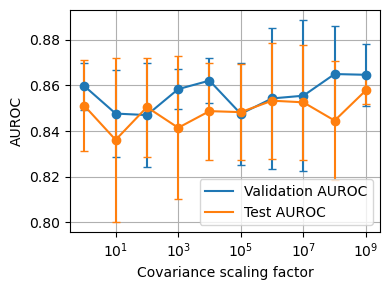

In [21]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
# Validation
ax.plot(df.prior_scale, df.val_auroc, label='Validation AUROC', color='#1f77b4')
ax.errorbar(df.prior_scale, df.val_auroc, yerr=df.val_auroc_std, fmt='o', capsize=3, color='#1f77b4')
# Test
ax.plot(df.prior_scale, df.test_auroc, label='Test AUROC', color='#ff7f0e')
ax.errorbar(df.prior_scale, df.test_auroc, yerr=df.test_auroc_std, fmt='o', capsize=3, color='#ff7f0e')
# Formatting
ax.set_xscale('log')
ax.set_xlabel('Covariance scaling factor')
ax.set_ylabel('AUROC')
ax.grid()
ax.legend()
fig.tight_layout()
plt.show()

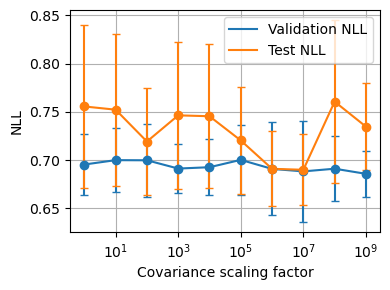

In [22]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
# Validation
ax.plot(df.prior_scale, df.val_nll, label='Validation NLL', color='#1f77b4')
ax.errorbar(df.prior_scale, df.val_nll, yerr=df.val_nll_std, fmt='o', capsize=3, color='#1f77b4')
# Test
ax.plot(df.prior_scale, df.test_nll, label='Test NLL', color='#ff7f0e')
ax.errorbar(df.prior_scale, df.test_nll, yerr=df.test_nll_std, fmt='o', capsize=3, color='#ff7f0e')
# Formatting
ax.set_xscale('log')
ax.set_xlabel('Covariance scaling factor')
ax.set_ylabel('NLL')
ax.grid()
ax.legend()
fig.tight_layout()
plt.show()